# PR Forecast 2082: Model Backtesting (District Holdout)

This notebook evaluates the PR vote-share model using **district-level holdout** to estimate how well the approach generalizes to unseen districts.

**Why district holdout?**
- PR vote dynamics differ by geography (local party strength, demographics, migration)
- Random row-splits would leak district-specific patterns across train/test
- Grouped evaluation tests whether the model learns transferable relationships

**What this notebook covers**
- Loading backtest predictions and metrics
- Core accuracy metrics (MAE/RMSE) and diagnostic plots
- Error analysis by party size and by district
- Sanity checks: calibration-like behavior and common failure modes


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 60)



In [2]:
os.chdir(r"C:\Users\dipes\Desktop\election-analytics-nepal-2082")
print(os.getcwd())

C:\Users\dipes\Desktop\election-analytics-nepal-2082


In [3]:
PRED_PATH = "data/outputs/pr_backtest_heldout_predictions.csv"
METRICS_PATH = "data/outputs/pr_backtest_metrics.json"


In [4]:
pred = pd.read_csv(PRED_PATH)

with open(METRICS_PATH, "r", encoding="utf-8") as f:
    metrics = json.load(f)

pred.shape, metrics



((752, 40),
 {'outer_test_size': 0.2,
  'inner_splits': 5,
  'ridge': {'model_name': 'ridge',
   'mae_change': 0.7626857264399084,
   'rmse_change': 1.839698766330895,
   'vote_share_mae': 0.73683367491407,
   'best_params': {'model__alpha': 112.88378916846884}},
  'elasticnet': {'model_name': 'elasticnet',
   'mae_change': 0.7236431802558673,
   'rmse_change': 1.827214618787589,
   'vote_share_mae': 0.7236431802558673,
   'best_params': {'model__alpha': 0.1668100537200059,
    'model__l1_ratio': 0.7}},
  'xgboost': {'model_name': 'xgboost',
   'mae_change': 0.6256217846624114,
   'rmse_change': 1.6926385112243905,
   'vote_share_mae': 0.6167879856331464,
   'best_params': {'max_depth': 4,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 1.0,
    'reg_lambda': 2.0}},
  'winner': 'xgboost'})

In [5]:
pred.head(5)


,district_id,party_id,election_year,vote_share,vote_share_lag,vote_share_change,is_new_party,Absent rate within country 2078,Absent rate abroad 2078,Literacy Rate 2078,Primary Education % 2078,Lower Secondary % 2078,Upper Secondary % 2078,SLC or SEE % 2078,Intermediate & equivalent % 2078,Graduate & equivalent % 2078,Post graduate equivalent & above % 2078,IS_ALTERNATIVE_FORCE?,GenZ_and_Youth_Favored?,Was_Part_Of_Ousted_Government?,IS_Major?,Facebook_Presence (In Thousands),Top_leader_fb (in Thousands),age_18-29_ratio,age_30-39_ratio,age_40-49_ratio,age_50-59_ratio,age_60-69_ratio,age_70+_ratio,female_ratio,valid_turnout,valid_turnout_lag,facebook_log,leader_following_log,under_40_ratio,40-60_ratio,SEE-Inter,Grad+,pred_change,pred_vote_share
0,1,P001,2079,42.369621,44.075145,-1.705523,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,350.0,650.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.860786,6.478510,0.469848,0.32162,19.06,3.65,-3.092085,40.983059
1,1,P002,2079,34.007651,31.449762,2.557889,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,300.0,621.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.707110,6.432940,0.469848,0.32162,19.06,3.65,-1.001073,30.448689
2,1,P003,2079,11.156498,13.475434,-2.318936,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,1,1,160.0,700.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.081404,6.552508,0.469848,0.32162,19.06,3.65,-1.085750,12.389683
3,1,P004,2079,2.113726,0.000000,2.113726,1,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,1,1,0,0,250.0,1200.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,5.525453,7.090910,0.469848,0.32162,19.06,3.65,3.663683,3.663683
4,1,P005,2079,1.376732,1.232574,0.144158,0,7.14,5.17,82.21,30.53,21.99,19.39,9.24,9.82,2.58,1.07,0,0,0,0,40.0,850.0,0.208919,0.26093,0.179692,0.141929,0.113764,0.094767,0.466727,52.41,60.02,3.713572,6.746412,0.469848,0.32162,19.06,3.65,-0.518785,0.713789


## Backtest file schema (held-out districts)

Each row is **district × party** for the held-out set.

Key columns:
- `vote_share` (actual, 2079)
- `pred_vote_share` (predicted, 2079)
- `vote_share_lag` (previous election share, 2074): used for naive baseline
- `vote_share_change` (actual change)
- `pred_change` (predicted change)

The remaining columns are features (demographics, turnout, party flags, digital presence).


In [6]:
pred = pred.copy()

pred["residual_share"] = pred["pred_vote_share"] - pred["vote_share"]
pred["abs_error_share"] = pred["residual_share"].abs()
pred["sq_error_share"] = pred["residual_share"] ** 2

mae_share = pred["abs_error_share"].mean()
rmse_share = np.sqrt(pred["sq_error_share"].mean())

mae_share, rmse_share



(np.float64(0.6167879856331463), np.float64(1.6912278743869904))

In [7]:
pred["residual_change"] = pred["pred_change"] - pred["vote_share_change"]
pred["abs_error_change"] = pred["residual_change"].abs()
pred["sq_error_change"] = pred["residual_change"] ** 2

mae_change = pred["abs_error_change"].mean()
rmse_change = np.sqrt(pred["sq_error_change"].mean())

mae_change, rmse_change


(np.float64(0.6256217862481317), np.float64(1.6926385141177576))

## Metric interpretation

We report accuracy in two related targets:

### 1) Vote share error
- MAE in vote-share points (0–100 scale)
- This is the easiest number to interpret.

### 2) Vote share change error
- Evaluates how well the model captures *swing dynamics*
- Helpful because the model is trained to predict change rather than raw share.

Even if district-level errors exist, national aggregation will smooth some noise, but district performance still matters for:
- identifying which parties may cross the 3% national threshold
- seat allocation outcomes under Sainte-Laguë


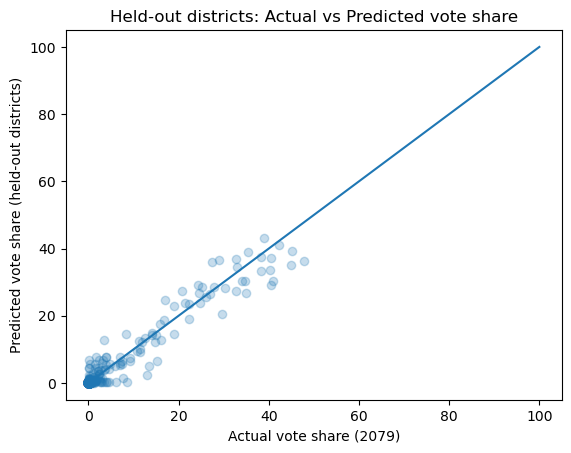

In [8]:
plt.figure()
plt.scatter(pred["vote_share"], pred["pred_vote_share"], alpha=0.25)
plt.plot([0, 100], [0, 100])
plt.xlabel("Actual vote share (2079)")
plt.ylabel("Predicted vote share (held-out districts)")
plt.title("Held-out districts: Actual vs Predicted vote share")
plt.show()



### What to look for in this plot
- Points close to the diagonal mean good predictions.
- Systematic patterns may indicate:
  - compression of extremes (underpredicting very high vote shares)
  - overprediction of tiny parties (predicting small positives)
  - missing “shock” dynamics for parties without historical support



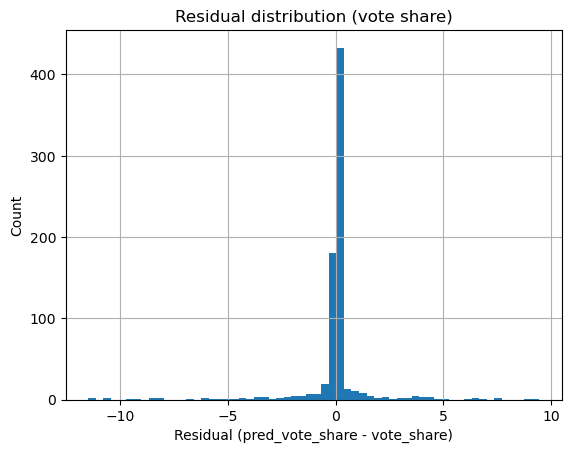

In [9]:
plt.figure()
pred["residual_share"].hist(bins=60)
plt.xlabel("Residual (pred_vote_share - vote_share)")
plt.ylabel("Count")
plt.title("Residual distribution (vote share)")
plt.show()


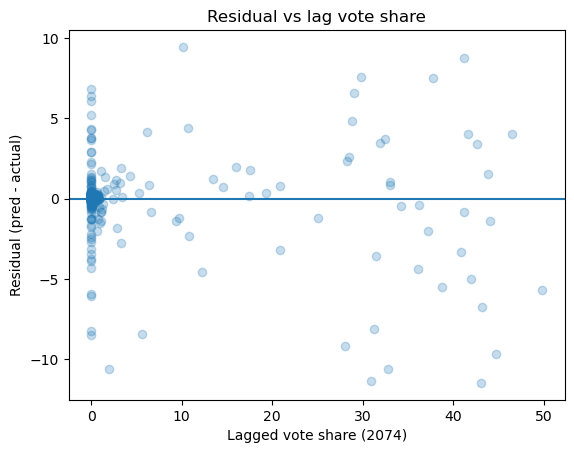

In [10]:
plt.figure()
plt.scatter(pred["vote_share_lag"], pred["residual_share"], alpha=0.25)
plt.axhline(0)
plt.xlabel("Lagged vote share (2074)")
plt.ylabel("Residual (pred - actual)")
plt.title("Residual vs lag vote share")
plt.show()



## Sanity check: does the model just copy the past?

A naive baseline is:  
**predict 2079 share = 2074 share** (i.e., `vote_share_lag`)

If the model cannot beat this baseline on held-out districts, it’s not learning useful structure.



In [11]:
pred["naive_pred_share"] = pred["vote_share_lag"]
pred["naive_abs_error_share"] = (pred["naive_pred_share"] - pred["vote_share"]).abs()

mae_naive = pred["naive_abs_error_share"].mean()

print(f"Model MAE (vote share): {mae_share:.3f}")
print(f"Naive MAE (vote_share_lag): {mae_naive:.3f}")


Model MAE (vote share): 0.617
Naive MAE (vote_share_lag): 0.746


## Error by party size

District × party tables contain many small parties.  
If we treat every row equally, the evaluation can be dominated by micro-parties.

To interpret results fairly, we compute error by party-size buckets using the party’s **average lag share** as a proxy for party strength.



In [12]:
party_strength = (
    pred.groupby("party_id")["vote_share_lag"]
    .mean()
    .rename("avg_party_strength_lag")
    .reset_index()
)

p2 = pred.merge(party_strength, on="party_id", how="left")

bins = [-0.1, 1, 5, 15, 100]
labels = ["micro (<=1%)", "small (1-5%)", "mid (5-15%)", "major (15%+)"]
p2["party_bucket"] = pd.cut(p2["avg_party_strength_lag"], bins=bins, labels=labels)

p2["party_bucket"].value_counts().reindex(labels)



party_bucket
micro (<=1%)    656
small (1-5%)     48
mid (5-15%)       0
major (15%+)     48
Name: count, dtype: int64

In [13]:
bucket_mae = p2.groupby("party_bucket")["abs_error_share"].mean().reindex(labels)
bucket_cnt = p2.groupby("party_bucket")["abs_error_share"].size().reindex(labels)

bucket_mae, bucket_cnt



C:\Users\dipes\AppData\Local\Temp\ipykernel_12776\2273292735.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_mae = p2.groupby("party_bucket")["abs_error_share"].mean().reindex(labels)
C:\Users\dipes\AppData\Local\Temp\ipykernel_12776\2273292735.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_cnt = p2.groupby("party_bucket")["abs_error_share"].size().reindex(labels)


(party_bucket
 micro (<=1%)    0.338951
 small (1-5%)    0.943241
 mid (5-15%)          NaN
 major (15%+)    4.087437
 Name: abs_error_share, dtype: float64,
 party_bucket
 micro (<=1%)    656
 small (1-5%)     48
 mid (5-15%)       0
 major (15%+)     48
 Name: abs_error_share, dtype: int64)

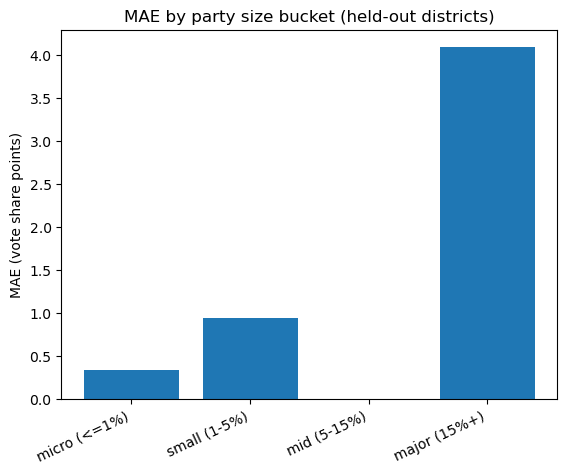

In [14]:
plt.figure()
plt.bar(bucket_mae.index.astype(str), bucket_mae.values)
plt.xticks(rotation=25, ha="right")
plt.ylabel("MAE (vote share points)")
plt.title("MAE by party size bucket (held-out districts)")
plt.show()



## Error by district

Because this is a district-holdout evaluation, we also inspect:
- which districts are hardest
- whether errors concentrate in a few districts (suggesting missing drivers)

This helps justify future work such as candidate data or region-specific factors (later, FPTP).


In [15]:
district_mae = pred.groupby("district_id")["abs_error_share"].mean().sort_values(ascending=False)
district_mae.head(20)



district_id
34    1.139418
67    1.041804
59    0.716783
11    0.698389
46    0.663728
29    0.660021
36    0.623384
75    0.577084
48    0.563924
13    0.529430
54    0.512952
69    0.499935
5     0.498422
1     0.420695
51    0.388589
19    0.334048
Name: abs_error_share, dtype: float64

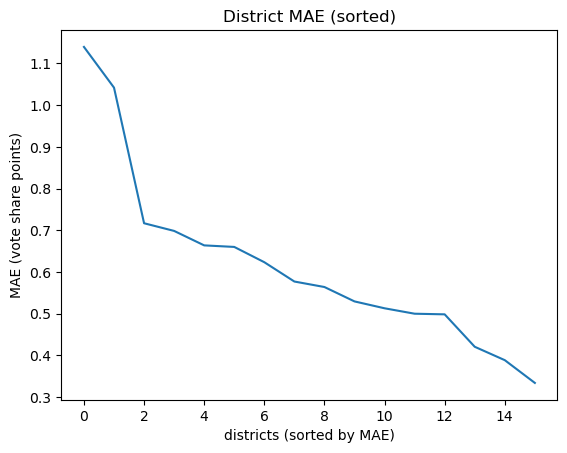

In [16]:
plt.figure()
plt.plot(district_mae.values)
plt.title("District MAE (sorted)")
plt.xlabel("districts (sorted by MAE)")
plt.ylabel("MAE (vote share points)")
plt.show()


## Largest misses (qualitative diagnostics)

The largest errors are the most informative:
- potential missing “new party surge”
- local alliances / splits not encoded
- turnout shifts not captured perfectly
- district-specific shocks

Inspecting these helps explain why the repo includes a transparent scenario layer later (consolidation + sentiment tilt + shock scenario).


In [17]:
cols_show = [
    "district_id", "party_id",
    "vote_share_lag", "vote_share_change", "pred_change",
    "vote_share", "pred_vote_share",
    "abs_error_share"
]
pred.sort_values("abs_error_share", ascending=False)[cols_show].head(30)



,district_id,party_id,vote_share_lag,vote_share_change,pred_change,vote_share,pred_vote_share,abs_error_share
612,67,P002,43.045715,4.679929,-6.797386,47.725644,36.248329,11.477315
517,54,P001,30.922827,9.469095,-1.862548,40.391923,29.060279,11.331643
425,48,P003,1.951589,11.137347,0.511196,13.088936,2.462785,10.626151
94,11,P001,32.813902,8.173127,-2.446508,40.987029,30.367394,10.619635
611,67,P001,44.688304,0.182878,-9.465741,44.871182,35.222563,9.648620
613,67,P003,10.176133,-6.801282,2.651121,3.374851,12.827254,9.452403
283,34,P002,28.071110,1.522371,-7.645809,29.593481,20.425301,9.168180
95,11,P002,41.195507,-13.862992,-5.096455,27.332516,36.099053,8.766537
332,36,P004,0.000000,15.101233,6.639418,15.101233,6.639418,8.461815
568,59,P005,5.569346,7.859444,-0.552598,13.428790,5.016748,8.412042


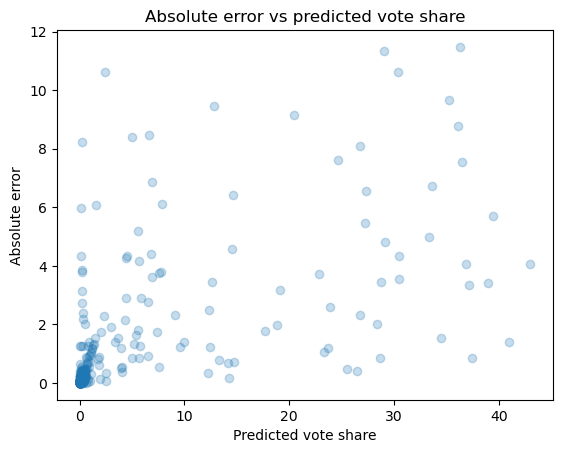

In [18]:
plt.figure()
plt.scatter(pred["pred_vote_share"], pred["abs_error_share"], alpha=0.25)
plt.xlabel("Predicted vote share")
plt.ylabel("Absolute error")
plt.title("Absolute error vs predicted vote share")
plt.show()



In [19]:
w = pred["vote_share_lag"].clip(lower=0.1)
weighted_mae = np.average(pred["abs_error_share"], weights=w)
weighted_mae


np.float64(4.098623516893996)

## Summary

This backtest provides evidence that the model:
- generalizes across districts using a group-holdout strategy
- performs differently by party size (major vs micro parties)
- has identifiable failure modes that motivate scenario overlays




